### Import stuff

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.signal import savgol_filter
from scipy.spatial import distance
from librosa.sequence import dtw
from tqdm import trange, tqdm
import networkx as nx
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon, Point, MultiLineString, LineString, shape, JOIN_STYLE
from shapely.geometry.polygon import LinearRing
from shapely.ops import snap, unary_union

In [2]:
cd /Users/zoltan/Dropbox/Channels/meanderpy/meanderpy

/Users/zoltan/Dropbox/Channels/meanderpy/meanderpy


In [3]:
import meanderpy as mp

In [4]:
cd /Users/zoltan/Dropbox/meandergraph

/Users/zoltan/Dropbox/Meandergraph


In [5]:
import meandergraph as mg

In [6]:
%matplotlib qt

In [7]:
import sys
print(sys.executable)

/Users/zoltan/anaconda3/envs/meanderpy/bin/python


### Build meanderpy model

In [8]:
nit = 2000                   # number of iterations
W = 200.0                    # channel width (m)
D = 6.0                      # channel depth (m)
depths = D * np.ones((nit,))  # channel depths for different iterations  
pad = 100                    # padding (number of nodepoints along centerline)
deltas = 50.0                # sampling distance along centerline           
Cfs = 0.011 * np.ones((nit,)) # dimensionless Chezy friction factor
crdist = 2 * W               # threshold distance at which cutoffs occur
kl = 60.0/(365*24*60*60.0)   # migration rate constant (m/s)
kv =  1.0e-12               # vertical slope-dependent erosion rate constant (m/s)
dt = 2*0.05*365*24*60*60.0     # time step (s)
dens = 1000                  # density of water (kg/m3)
saved_ts = 10                # which time steps will be saved
n_bends = 30                 # approximate number of bends you want to model
Sl = 0.0                     # initial slope (matters more for submarine channels than rivers)
t1 = 500                    # time step when incision starts
t2 = 700                    # time step when lateral migration starts
t3 = 1200                    # time step when aggradation starts
aggr_factor = 2e-9         # aggradation factor (m/s, about 0.18 m/year, it kicks in after t3)

ch = mp.generate_initial_channel(W, depths[0], Sl, deltas, pad, n_bends) # initialize channel
chb = mp.ChannelBelt(channels=[ch], cutoffs=[], cl_times=[0.0], cutoff_times=[]) # create channel belt object

chb.migrate(nit,saved_ts,deltas,pad,crdist,depths,Cfs,kl,kv,dt,dens,t1,t2,t3,aggr_factor) # channel migration
fig = chb.plot('strat', 20, 60, chb.cl_times[-1], len(chb.channels)) # plotting

100%|██████████| 2000/2000 [00:51<00:00, 38.86it/s]


In [24]:
fig = chb.plot('strat', 20, 60, chb.cl_times[-1], len(chb.channels)) # plotting

In [20]:
points = plt.ginput(n=2) # click twice to select start- and endpoints on first centerline

In [19]:
from scipy import signal, spatial
cl_points = np.vstack((chb.channels[0].x, chb.channels[0].y)).T # coordinates of first centerlines
tree = spatial.KDTree(cl_points)
plt.plot(chb.channels[0].x[tree.query(points[0])[1]], chb.channels[0].y[tree.query(points[0])[1]], 
         'ro', zorder=10000)
plt.plot(chb.channels[0].x[tree.query(points[1])[1]], chb.channels[0].y[tree.query(points[1])[1]], 
         'ro', zorder=10000)

In [27]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
len(chb.channels)

200

### Resample and correlate centerlines and banklines

In [30]:
first_index = tree.query(points[0])[1]
last_index = tree.query(points[1])[1]

first_channel = 60
last_channel = 200

# create lists of x, y, z coordinates from channel belt object:
X = []
Y = []
Z = []
for i in range(first_channel, last_channel):
    X.append(chb.channels[i].x)
    Y.append(chb.channels[i].y)
    Z.append(chb.channels[i].z)

# correlate all centerlines:    
P = []
Q = []
for i in trange(len(X) - 1):
    p, q = mg.correlate_curves(X[i], X[i+1], Y[i], Y[i+1])
    P.append(p)
    Q.append(q)

indices1, x, y = mg.find_indices(first_index, X, Y, P, Q)
indices2, x, y = mg.find_indices(last_index, X, Y, P, Q)
for i in range(len(X)):
    X[i] = X[i][indices1[i] : indices2[i]+1]
    Y[i] = Y[i][indices1[i] : indices2[i]+1]
    Z[i] = Z[i][indices1[i] : indices2[i]+1]

# create bank coordinates:
X1 = [] # right bank x coordinate
X2 = [] # left bank x coordinate
Y1 = [] # right bank y coordinate
Y2 = [] # left bank y coordinate
for i in range(len(X)):
    x1 = X[i].copy()
    y1 = Y[i].copy()
    x2 = X[i].copy()
    y2 = Y[i].copy()
    x = X[i].copy()
    y = Y[i].copy()
    ns = len(x)
    dx = np.diff(x); dy = np.diff(y) 
    ds = np.sqrt(dx**2+dy**2)
    x1[:-1] = x[:-1] + 0.5*W*np.diff(y)/ds
    y1[:-1] = y[:-1] - 0.5*W*np.diff(x)/ds
    x2[:-1] = x[:-1] - 0.5*W*np.diff(y)/ds
    y2[:-1] = y[:-1] + 0.5*W*np.diff(x)/ds
    x1[ns-1] = x[ns-1] + 0.5*W*(y[ns-1]-y[ns-2])/ds[ns-2]
    y1[ns-1] = y[ns-1] - 0.5*W*(x[ns-1]-x[ns-2])/ds[ns-2]
    x2[ns-1] = x[ns-1] - 0.5*W*(y[ns-1]-y[ns-2])/ds[ns-2]
    y2[ns-1] = y[ns-1] + 0.5*W*(x[ns-1]-x[ns-2])/ds[ns-2]
    X1.append(x1)
    X2.append(x2)
    Y1.append(y1)
    Y2.append(y2)
    
# resample centerlines to ds = 1.0 meters:
for i in range(len(X)):
    x,y,z,dx,dy,dz,ds,s = mp.resample_centerline(X[i], Y[i], Z[i], 1.0)
    X[i] = x
    Y[i] = y
for i in range(len(X1)):
    x,y,z,dx,dy,dz,ds,s = mp.resample_centerline(X1[i], Y1[i], Z[i], 1.0)
    X1[i] = x
    Y1[i] = y
for i in range(len(X2)):
    x,y,z,dx,dy,dz,ds,s = mp.resample_centerline(X2[i], Y2[i], Z[i], 1.0)
    X2[i] = x
    Y2[i] = y

P, Q = mg.correlate_set_of_curves(X, Y)
P1, Q1 = mg.correlate_set_of_curves(X1, Y1)
P2, Q2 = mg.correlate_set_of_curves(X2, Y2)

100%|██████████| 139/139 [54:14<00:00, 23.41s/it]


In [31]:
plt.figure()
plt.plot(X1[100], Y1[100])
plt.plot(X2[100], Y2[100])

In [39]:
from importlib import reload
reload(mg)

<module 'meandergraph' from '/Users/zoltan/Dropbox/Meandergraph/meandergraph/meandergraph.py'>

In [32]:
len(X)

140

### Create centerline- and bank graphs

In [34]:
# reload(mg)
ts = 140
graph = mg.create_graph_from_channel_lines(X[:ts], Y[:ts], P[:ts-1], Q[:ts-1], n_points=20, max_dist=100, remove_cutoff_edges=True)
graph1 = mg.create_graph_from_channel_lines(X1[:ts], Y1[:ts], P1[:ts-1], Q1[:ts-1], n_points=20, max_dist=100, remove_cutoff_edges=True)
graph2 = mg.create_graph_from_channel_lines(X2[:ts], Y2[:ts], P2[:ts-1], Q2[:ts-1], n_points=20, max_dist=100, remove_cutoff_edges=True)

100%|██████████| 140/140 [00:00<00:00, 239.93it/s]


In [40]:
graph = mg.remove_high_density_nodes(graph, min_dist = 10, max_dist = 30)
graph1 = mg.remove_high_density_nodes(graph1, min_dist = 10, max_dist = 30)
graph2 = mg.remove_high_density_nodes(graph2, min_dist = 10, max_dist = 30)

100%|██████████| 140/140 [00:14<00:00,  9.83it/s]


### Plot one of the graphs

In [126]:
fig = plt.figure()
ax = fig.add_subplot(111)
mg.plot_graph(graph1, ax)
plt.axis('equal');

(21820.838746150006,
 30460.123621268773,
 -3215.741164828904,
 3117.1173138346417)

### Create and plot scrolls and bars (connected scrolls)

In [41]:
cutoff_area = 0.25*1e6
fig = plt.figure()
ax = fig.add_subplot(111)
scrolls, scroll_ages, all_bars_graph, cutoffs = mg.create_scrolls_and_find_connected_scrolls(graph, W, cutoff_area, ax)
plt.axis('equal');

100%|██████████| 139/139 [00:01<00:00, 78.53it/s]


### Create and plot 'bar graphs', colored by migration rate

In [42]:
fig = plt.figure(figsize = (15, 9))
ax = fig.add_subplot(111)
wbars, poly_graph_1, poly_graph_2 = mg.create_and_plot_bar_graphs(graph1, graph2, ts, all_bars_graph, scrolls, scroll_ages, cutoffs, dt, X, Y, W, saved_ts, ax)
ax.set_adjustable("box")
ax.axis('equal');

100%|██████████| 4378/4378 [00:22<00:00, 191.10it/s]
0it [00:00, ?it/s]
100%|██████████| 10068/10068 [00:33<00:00, 296.68it/s]
0it [00:00, ?it/s]
100%|██████████| 541/541 [00:01<00:00, 450.07it/s]
0it [00:00, ?it/s]


(21756.70065313041, 31816.656911270962, -3225.79446454881, 3327.0346575743306)

In [43]:
areas = []
for wbar in wbars:
    areas.append(wbar.polygon.area)
np.where(np.array(areas) > 1000)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 12, 13, 14, 15, 16, 18, 19,
        20]),)

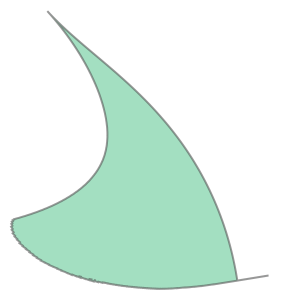

In [69]:
wbars[2].polygon

In [59]:
# 1 - right bank
# 2 - left bank
wbars[12].add_polygon_graphs(poly_graph_2)
mg.plot_migration_rate_map(wbars[12], graph2, 0, 40, dt, saved_ts, ax)

100%|██████████| 2910/2910 [00:05<00:00, 521.77it/s]


In [124]:
x = X[-1]
y = Y[-1]
x1 = x.copy()
y1 = y.copy()
x2 = x.copy()
y2 = y.copy()
ns = len(x)
dx = np.diff(x); dy = np.diff(y) 
ds = np.sqrt(dx**2+dy**2)
x1[:-1] = x[:-1] + 0.5*W*np.diff(y)/ds
y1[:-1] = y[:-1] - 0.5*W*np.diff(x)/ds
x2[:-1] = x[:-1] - 0.5*W*np.diff(y)/ds
y2[:-1] = y[:-1] + 0.5*W*np.diff(x)/ds
x1[ns-1] = x[ns-1] + 0.5*W*(y[ns-1]-y[ns-2])/ds[ns-2]
y1[ns-1] = y[ns-1] - 0.5*W*(x[ns-1]-x[ns-2])/ds[ns-2]
x2[ns-1] = x[ns-1] - 0.5*W*(y[ns-1]-y[ns-2])/ds[ns-2]
y2[ns-1] = y[ns-1] + 0.5*W*(x[ns-1]-x[ns-2])/ds[ns-2]
fig = plt.figure(figsize = (15, 9))
ax = fig.add_subplot(111)
plt.plot(x1, y1)
plt.plot(x2, y2)
plt.axis('equal');

(21832.910007617793,
 31813.027894390612,
 -2876.3360533390714,
 3310.3937808500573)

In [125]:
fig.savefig('temp.svg')

In [970]:
# code for debugging bar polygons
fig = plt.figure()
ax = fig.add_subplot(111)
mg.plot_migration_rate_map(wbars[21], graph2, vmin=0, vmax=40, dt=dt, saved_ts=saved_ts, ax=ax)
plt.axis('equal');

from shapely.geometry import Point
nodes = []
for node in graph2.nodes:
    point = Point(graph2.nodes[node]['x'], graph2.nodes[node]['y'])
    if wbars[21].polygon.contains(point):
        nodes.append(node)
        
for node in nodes:
    plt.plot(graph2.nodes[node]['x'], graph2.nodes[node]['y'], 'k.')
    plt.text(graph2.nodes[node]['x'], graph2.nodes[node]['y'], str(node))

100%|██████████| 496/496 [00:05<00:00, 94.77it/s] 


### Plot scroll- and radial lines for one bar

In [77]:
# this doesn't work well for long-term evolution
bar_ind = 13
fig = plt.figure()
ax = fig.add_subplot(111)
plt.axis('equal');
mg.plot_bar_lines(wbars, bar_ind, graph2, ax)

### Plot scroll- and radial lines for all bars

In [118]:
fig = plt.figure()
ax = fig.add_subplot(111)

# create polygon for most recent channel and plot it:
xm, ym = mp.get_channel_banks(X[ts-1], Y[ts-1], W)
coords = []
for i in range(len(xm)):
    coords.append((xm[i],ym[i]))
ch = Polygon(LinearRing(coords))
ax.add_patch(PolygonPatch(ch, facecolor='lightblue', edgecolor='k'))

for i in range(len(wbars)):
    lb_boundary_length = wbars[i].polygon.buffer(1).intersection(LineString(coords[:int(len(coords)/2)])).length
    if lb_boundary_length > 500:
        mg.plot_bar_lines(wbars, i, graph1, ax)
    rb_boundary_length = wbars[i].polygon.buffer(1).intersection(LineString(coords[int(len(coords)/2):])).length
    if rb_boundary_length > 500:
        mg.plot_bar_lines(wbars, i, graph2, ax)
plt.axis('equal');

### Plot radial lines only

In [111]:
fig = plt.figure()
ax = fig.add_subplot(111)
path = mg.find_longitudinal_path(graph2, graph2.graph['start_nodes'][0])
for node in path:
    radial_path, dummy = mg.find_radial_path(graph2, node)
    x = graph2.graph['x'][radial_path]
    y = graph2.graph['y'][radial_path]
    plt.plot(x, y, 'k', linewidth = 0.5)
plt.axis('equal');

### Create and plot 'simple' polygon graph (with only primary radial lines)

In [95]:
graph_poly = mg.create_simple_polygon_graph(graph2, X[:ts]) # graph2 is left bank
fig = plt.figure()
ax = fig.add_subplot(111)
mg.plot_simple_polygon_graph(graph_poly, ax, 'left')
plt.axis('equal');

100%|██████████| 391/391 [00:19<00:00, 20.54it/s]


In [79]:
path = mg.find_longitudinal_path(graph, graph.graph['start_nodes'][0])

In [114]:
# plot individual polygon 'trajectories'
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(2, len(path), 5):
    radial_path = mg.find_radial_path_2(graph_poly, path[i])
    count = 0
    bank_type = 'left'
    cmap = plt.get_cmap("tab10")
    for node in radial_path:
        if 'poly' in graph_poly.nodes[node].keys():
            if graph_poly.nodes[node]['poly']:
                if bank_type == 'left':
                    if graph_poly.nodes[node]['direction'] == -1:
                        ax.add_patch(PolygonPatch(graph_poly.nodes[node]['poly'], facecolor = cmap(1), edgecolor='k', 
                                                  linewidth = 0.3, alpha = 0.5, zorder = count))
                    if graph_poly.nodes[node]['direction'] == 1:
                        ax.add_patch(PolygonPatch(graph_poly.nodes[node]['poly'], facecolor = cmap(0), edgecolor='k', 
                                                  linewidth = 0.3, alpha = 0.5, zorder = count))
        count += 1
plt.axis('equal');                    

### Create movie frames

In [800]:
# ts = 50
for ts in range(40, 125):
    graph = mg.create_graph_from_channel_lines(X[:ts], Y[:ts], P[:ts-1], Q[:ts-1], n_points=20, max_dist=100, remove_cutoff_edges=True)
    graph1 = mg.create_graph_from_channel_lines(X1[:ts], Y1[:ts], P1[:ts-1], Q1[:ts-1], n_points=20, max_dist=100, remove_cutoff_edges=True)
    graph2 = mg.create_graph_from_channel_lines(X2[:ts], Y2[:ts], P2[:ts-1], Q2[:ts-1], n_points=20, max_dist=100, remove_cutoff_edges=True)

    cutoff_area = 0.25*1e6
    fig = plt.figure()
    ax = fig.add_subplot(111)
    scrolls, scroll_ages, all_bars_graph = create_scrolls_and_find_connected_scrolls(graph, W, cutoff_area, ax)
    plt.axis('equal')
    plt.close('all')

    fig = plt.figure(figsize = (15, 9))
    ax = fig.add_subplot(111)
    wbars, poly_graph_1, poly_graph_2 = mg.create_and_plot_bar_graphs(graph1, graph2, ts, all_bars_graph, scrolls, scroll_ages, cutoffs, dt, X, Y, W, saved_ts, ax)
    ax.set_adjustable("box")
    ax.axis('equal')
    ax.set_xlim(6500, 12000)
    ax.set_ylim(ylim)
    fname = 'example_1_'+'%03d.png'%(ts-40)
    fig.savefig(fname, bbox_inches='tight')
    plt.close('all')

 83%|████████▎ | 94/113 [00:07<00:01, 11.75it/s]


KeyboardInterrupt: 

In [790]:
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()

In [836]:
# this doesn't work well at this point
n_centerlines = graph2.graph['number_of_centerlines']
curvs = []
for cline in range(0, n_centerlines-1):
    path = mg.find_longitudinal_path(graph2, cline)
    curv = mp.compute_curvature(graph2.graph['x'][path], graph2.graph['y'][path])
    curv = savgol_filter(curv, 31, 2)
    count = 0
    for node in path:
        graph2.nodes[node]['curv'] = curv[count]
        count += 1

for node in graph2.nodes:
    if 'curv' not in graph2.nodes[node].keys():
        graph2.nodes[node]['curv'] = 0

fig = plt.figure()
ax = fig.add_subplot(111)
mg.plot_curvature_map(wbars[10], graph2, vmin=-0.7, vmax=0.7, W=W, ax=ax)
plt.axis('equal');